In [1]:
import pandas as pd
import numpy as np
from  graphviz import Source
from scipy import misc
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

#### Importar dados para analise
Para iniciar a analise dos dados primeiro necessita-se
importar esse dados, os .csv encontrados abaixo são os dados disponibilizados
[aqui](https://archive.ics.uci.edu/ml/datasets/record+linkage+comparison+patterns).
Após carregar cada um dos dados .csv unimos em um unico frame do pandas.

In [2]:
dataframe = pd.DataFrame()
for x in range(1,11):
    dataframe_name = 'data/block_'+str(x)+'.csv'
    new_dataframe = pd.read_csv(dataframe_name)
    dataframe = pd.concat([dataframe,new_dataframe])

frame = dataframe


#### Exibir Frame
Exibir resultado do merge dos frames..

In [21]:
frame.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,?,1.0,?,1,1,1,1,0,True
1,39086,47614,1,?,1.0,?,1,1,1,1,1,True
2,70031,70237,1,?,1.0,?,1,1,1,1,1,True
3,84795,97439,1,?,1.0,?,1,1,1,1,1,True
4,36950,42116,1,?,1.0,1,1,1,1,1,1,True


In [18]:
frame.tail()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
574908,39507,82513,1.0,NaN,0.285714,NaN,1,0.0,1.0,0.0,0.0,False
574909,20451,99586,1.0,NaN,0.125000,NaN,1,0.0,1.0,0.0,0.0,False
574910,62841,98890,1.0,NaN,0.090909,NaN,1,0.0,1.0,0.0,0.0,False
574911,7347,69456,1.0,NaN,0.111111,NaN,1,0.0,1.0,0.0,0.0,False
574912,23870,35371,1.0,NaN,0.000000,NaN,1,1.0,0.0,0.0,0.0,False


#### Arrumando tipos de dados

In [3]:
broken_columns = list(frame.columns[2:11])

for column in broken_columns:
    frame[column] = frame[column].apply(lambda x: np.NaN if x == '?' else x)
    frame[column] = frame[column].apply(lambda x: float(x) if type(x) == str else x)

#### Verificando a existência de valores nulos

In [4]:
imp_values = frame.drop(['is_match','id_1','id_2'],axis=1)
melted_frame = pd.melt(imp_values.notnull())

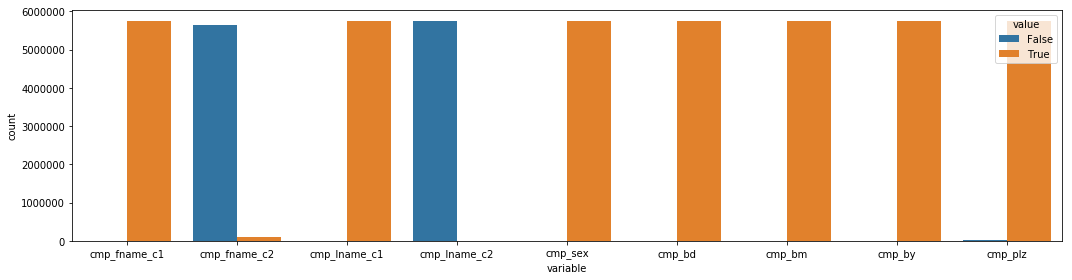

In [5]:
plt.figure(figsize=(15,4))
sns.countplot(melted_frame['variable'],hue=melted_frame['value'])
plt.tight_layout()

No gráfico acima as barras em azul representam o número de valores nulos de cada coluna

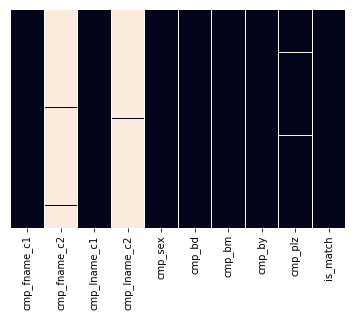

In [6]:
sns.heatmap(frame.drop(['id_1','id_2'],axis=1).isnull(),cbar=False,yticklabels=False)

Acima vemos outro gráfico que representa a quantidade de valores nulos de cada coluna. Nesse caso as partes claras
representam os valores faltantes

#### Removendo colunas vazias
Com o resultado da exibição do head e d tail do frame, observa-se a existencia de colunas
com dados nulos, para a utilização do do sklearn para a criação da arvore de decisão é 
necesario remover os dados em branco, ou no caso do dataset do problema os dados com valor '?',
para isso utilizamos o arquivo frequencies.cvs disponibilizado no dataset do problema, para fazer a substituição
dos valores nulos para a media dos valores da coluna.

In [7]:
def preparer_data(frame):
    frame["cmp_fname_c1"] = frame["cmp_fname_c1"].replace('?',0.000235404896421846)
    frame["cmp_fname_c2"] = frame["cmp_fname_c2"].replace('?',0.00147710487444609)
    frame["cmp_lname_c1"] = frame["cmp_lname_c1"].replace('?',2.68694413843136e-05)
    frame["cmp_lname_c2"] = frame["cmp_lname_c2"].replace('?',0.000641025641025641)
    frame["cmp_sex"] = frame["cmp_sex"].replace('?',0.5)
    frame["cmp_bd"] = frame["cmp_bd"].replace('?',0.032258064516129)
    frame["cmp_bm"] = frame["cmp_bm"].replace('?',0.0833333333333333)
    frame["cmp_by"] = frame["cmp_by"].replace('?', 0.00943396226415094)
    frame["cmp_plz"] = frame["cmp_plz"].replace('?', 0.000422654268808115)
    
    return frame

frame = preparer_data(frame)


In [10]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749132 entries, 0 to 574912
Data columns (total 12 columns):
id_1            int64
id_2            int64
cmp_fname_c1    object
cmp_fname_c2    object
cmp_lname_c1    float64
cmp_lname_c2    object
cmp_sex         int64
cmp_bd          object
cmp_bm          object
cmp_by          object
cmp_plz         object
is_match        bool
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 531.8+ MB


In [8]:
frame.head()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
0,37291,53113,0.833333333333333,0.0014771,1.0,0.000641026,1,1,1,1,0,True
1,39086,47614,1,0.0014771,1.0,0.000641026,1,1,1,1,1,True
2,70031,70237,1,0.0014771,1.0,0.000641026,1,1,1,1,1,True
3,84795,97439,1,0.0014771,1.0,0.000641026,1,1,1,1,1,True
4,36950,42116,1,0.0014771,1.0,1,1,1,1,1,1,True


In [9]:
frame.tail()

,id_1,id_2,cmp_fname_c1,cmp_fname_c2,cmp_lname_c1,cmp_lname_c2,cmp_sex,cmp_bd,cmp_bm,cmp_by,cmp_plz,is_match
574908,32517,73116,1,0.0014771,0.222222,0.000641026,1,0,1,0,0,False
574909,67707,83757,0.111111111111111,0.0014771,1.000000,0.000641026,1,0,0,0,0,False
574910,53258,91808,1,0.0014771,0.000000,0.000641026,1,0,0,1,0,False
574911,31865,85285,1,0.0014771,0.111111,0.000641026,1,0,1,0,0,False
574912,33119,76399,1,0.0014771,0.000000,0.000641026,1,0,1,0,0,False


#### Criação da coluna de alvos
Para conseguir classificar os dados de acordo com coluna de alvos,
onde o sklearn index valores numericos aos dados categoricos que deseja-se
obter a predição.

In [8]:
def make_target_frame(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod["Target"] = df_mod[target_column].map({True:0, False:1})
    return (df_mod, targets)
df2, targets = make_target_frame(frame, "is_match")


#### Exibição dos dados do Frame de alvos


In [9]:
df2[["Target", "is_match"]].head()


,Target,is_match
0,0,True
1,0,True
2,0,True
3,0,True
4,0,True


In [10]:
df2[["Target", "is_match"]].tail()


,Target,is_match
574908,1,False
574909,1,False
574910,1,False
574911,1,False
574912,1,False
